# Проект по дисцплине "Машинное обучение" студента группы ИАУП-22 Михайлова Александра Витальевича

Датасет для проекта содержит 10 000 записей с данными пациентов прошедших медицинский осмотр, в том числе:
1) возраст,
2) вес,
3) рост,
4) систолическое давление,
5) диастолическое давление,
6) пол,
7) территория проживания,
8) злоупотребление алкоголем (опрос),
9) иррациональное питание (опрос),
10) курение (опрос),
11) Количество оказанных услуг в поликлинике за год,
12) Количество оказанных услуг скорой помощи за год,
13) Количество оказанных услуг в стационаре за год,
14) Наличие болезни системы кровообращения.

На основе представленных данных преполагается решить следующие задачи:
1) Регрессия - расчет количества оказанных пациенту поликлинических услуг.
2) Классификация - определение наличия болезни системы кровообращения.
3) Кластеризация - разбиение пациентов на группы.

In [39]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from statistics import mean, stdev
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
import seaborn as sns
from mst_clustering import MSTClustering
from sklearn.cluster import KMeans

## 0. Загрузка и предобработка данных

Загрузим и просмотрим данные

In [40]:
df = pd.read_csv('data/health_data.csv')

In [41]:
df.head()

,age,weight,height,s_press,d_press,sex,area,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
0,45,88.0,158.0,130.0,80.0,Женский,Село,0.0,1.0,0.0,57,3,0,1
1,58,72.0,170.0,145.0,95.0,Мужской,Село,0.0,0.0,0.0,176,5,100,1
2,52,81.0,162.0,130.0,80.0,Женский,Село,0.0,0.0,0.0,76,2,9,1
3,66,62.0,160.0,140.0,80.0,Женский,Город,0.0,0.0,0.0,163,14,11,1
4,41,64.0,170.0,110.0,70.0,Женский,Город,0.0,0.0,0.0,79,0,0,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            10000 non-null  int64  
 1   weight         9470 non-null   float64
 2   height         9471 non-null   float64
 3   s_press        9368 non-null   float64
 4   d_press        9366 non-null   float64
 5   sex            10000 non-null  object 
 6   area           10000 non-null  object 
 7   alco           7706 non-null   float64
 8   irrat_food     7827 non-null   float64
 9   smoke          7875 non-null   float64
 10  clinic_cnt     10000 non-null  int64  
 11  ambulance_cnt  10000 non-null  int64  
 12  hosp_cnt       10000 non-null  int64  
 13  has_bsk        10000 non-null  int64  
dtypes: float64(7), int64(5), object(2)
memory usage: 1.1+ MB


In [43]:
df.describe()

,age,weight,height,s_press,d_press,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
count,10000.000000,9470.000000,9471.000000,9368.00000,9366.000000,7706.000000,7827.000000,7875.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,57.946800,117.256600,163.967163,130.08070,80.147341,0.066701,0.473106,0.089270,90.062900,4.125700,15.545300,0.574500
std,15.561111,1688.820277,9.977370,177.86144,16.844899,0.249520,0.499308,0.285151,58.096949,10.872236,38.329094,0.494443
min,17.000000,1.000000,1.000000,11.00000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000
25%,48.000000,65.000000,158.000000,120.00000,80.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000,0.000000
50%,60.000000,74.000000,164.000000,125.00000,80.000000,0.000000,0.000000,0.000000,78.000000,2.000000,5.000000,1.000000
75%,69.000000,84.000000,170.000000,130.00000,80.000000,0.000000,1.000000,0.000000,118.000000,5.000000,20.000000,1.000000
max,99.000000,82000.000000,205.000000,13070.00000,960.000000,1.000000,1.000000,1.000000,627.000000,615.000000,1399.000000,1.000000


### Проверка данных вручную
Из описания данных (максимальных и минимальных значений в столбцах) следует, что в наборе пристутсвуют явно некорректные значения. Например максимальное значение  веса составляет 82 000, что предположительно является ошибкой ввода данных - вместо кг данные внесены в граммах.

Попробуем проверить значения вручную

Проверим значения веса более 200

In [44]:
df[df.weight > 200]

,age,weight,height,s_press,d_press,sex,area,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
589,74,70000.0,154.0,140.0,80.0,Женский,Село,NaN,NaN,NaN,64,0,0,1
2012,61,58000.0,161.0,NaN,NaN,Мужской,Село,NaN,NaN,NaN,182,2,0,1
3377,37,47000.0,173.0,NaN,NaN,Женский,Город,NaN,NaN,NaN,275,31,27,0
5574,60,59000.0,161.0,NaN,NaN,Женский,Село,NaN,NaN,NaN,112,0,22,1
5805,30,1700.0,46.0,NaN,NaN,Женский,Город,NaN,NaN,NaN,151,20,11,0
8457,54,82000.0,170.0,NaN,NaN,Женский,Город,NaN,NaN,NaN,90,4,0,1
9429,70,80000.0,159.0,NaN,NaN,Женский,Село,NaN,NaN,NaN,52,0,0,1


Строка со значением веса 1700 и роста 46 явно является некорректной и ее нужно удалить, остальыне значения можно исправить, поделив на 1000

In [45]:
df = df[df.weight != 1700]

In [46]:
df.loc[(df.weight > 200), 'weight'] = df.weight/1000

Проверим значения веса менее 30 кг

In [47]:
df[df.weight < 30]

,age,weight,height,s_press,d_press,sex,area,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
4173,60,1.0,156.0,130.0,80.0,Женский,Город,0.0,1.0,0.0,65,1,0,1
5227,81,6.0,167.0,140.0,90.0,Мужской,Город,0.0,0.0,0.0,53,19,22,1


Значения веса явно некооректные, при этом данные в остальных столбцах не вызывают вопросов. Обнулим значения веса для этих строк и восстановим их по выборке на этапе работы с пропущенными данными

In [48]:
df.loc[(df.weight < 30), 'weight'] = np.NaN

Проверим значения роста менее 100

In [49]:
df[df.height < 100]

,age,weight,height,s_press,d_press,sex,area,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
298,29,110.0,75.0,110.0,75.0,Женский,Село,1.0,1.0,0.0,123,4,16,0
1569,66,171.0,73.0,120.0,80.0,Мужской,Город,0.0,1.0,0.0,64,2,0,1
2665,18,156.0,88.0,120.0,80.0,Женский,Село,0.0,1.0,0.0,71,2,0,0
3324,52,154.0,92.0,130.0,80.0,Женский,Город,0.0,0.0,0.0,222,3,44,1
4651,48,159.0,63.0,130.0,80.0,Женский,Село,0.0,1.0,0.0,48,7,36,0
5616,64,165.0,60.0,135.0,80.0,Мужской,Город,0.0,1.0,1.0,9,6,24,1
5709,61,56.0,68.0,120.0,80.0,Мужской,Город,0.0,1.0,0.0,16,0,0,0
6883,55,120.0,80.0,120.0,80.0,Мужской,Город,NaN,NaN,NaN,38,1,0,0
7130,70,82.0,1.0,130.0,80.0,Женский,Село,0.0,0.0,0.0,185,1,19,1
7276,62,161.0,73.0,122.0,73.0,Женский,Город,NaN,NaN,NaN,86,0,0,0


Значение роста 1 явно некорректное и подлежит удалению, остальные значения судя по всему ошибки ввода, их можно скорректировать прибавив к занчению 100

In [50]:
df = df[df.height != 1]

In [51]:
df.loc[(df.height < 100), 'height'] = df.height + 100

Проверим значения систолического давления меньше 50 или больше 200

In [52]:
df[(df.s_press < 50) | (df.s_press > 200)]

,age,weight,height,s_press,d_press,sex,area,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
631,72,67.0,168.0,17.0,17.0,Женский,Город,0.0,1.0,0.0,85,0,19,0
1008,18,44.0,166.0,11.0,70.0,Мужской,Город,NaN,NaN,NaN,40,1,0,0
1273,62,76.0,163.0,11148.0,80.0,Женский,Город,0.0,0.0,0.0,39,0,9,0
1552,78,78.0,164.0,1230.0,78.0,Женский,Город,0.0,1.0,0.0,43,1,0,1
1759,61,66.0,157.0,13.0,80.0,Женский,Село,0.0,0.0,0.0,88,1,0,1
2143,74,94.0,154.0,1470.0,80.0,Женский,Город,0.0,0.0,0.0,75,3,0,1
2419,60,66.0,172.0,20.0,18.0,Мужской,Город,0.0,0.0,0.0,34,5,11,1
3408,67,62.0,164.0,13070.0,NaN,Женский,Город,0.0,0.0,0.0,60,0,0,0
3655,26,59.0,160.0,1210.0,80.0,Мужской,Город,0.0,0.0,0.0,50,1,2,0
4722,46,100.0,164.0,18.0,18.0,Женский,Село,0.0,0.0,0.0,79,0,7,1


Значения явно некорректные, обнулим их для дальнейшего восстановления

In [53]:
df.loc[((df.s_press < 50) | (df.s_press > 200)), 's_press'] = np.NaN

Проверим значения диастолического давления меньше 50 или больше 200

In [54]:
df[(df.d_press < 50) | (df.d_press > 200)]

,age,weight,height,s_press,d_press,sex,area,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
509,70,75.0,164.0,130.0,740.0,Женский,Город,0.0,0.0,0.0,88,2,22,1
631,72,67.0,168.0,NaN,17.0,Женский,Город,0.0,1.0,0.0,85,0,19,0
2419,60,66.0,172.0,NaN,18.0,Мужской,Город,0.0,0.0,0.0,34,5,11,1
3067,65,87.0,175.0,120.0,710.0,Мужской,Село,0.0,0.0,0.0,201,13,46,1
3336,74,60.0,155.0,120.0,30.0,Женский,Город,0.0,1.0,0.0,42,3,14,1
4722,46,100.0,164.0,NaN,18.0,Женский,Село,0.0,0.0,0.0,79,0,7,1
6099,74,85.0,165.0,150.0,960.0,Женский,Город,0.0,0.0,0.0,210,14,36,1
7059,50,95.0,157.0,120.0,20.0,Женский,Село,0.0,0.0,1.0,62,1,0,0
7301,64,115.0,173.0,120.0,800.0,Женский,Город,0.0,0.0,0.0,23,0,0,1
7727,67,81.0,153.0,NaN,18.0,Женский,Село,0.0,0.0,0.0,84,2,0,1


Значения явно некорректные, обнулим их для дальнейшего восстановления

In [55]:
df.loc[((df.d_press < 50) | (df.d_press > 200)), 'd_press'] = np.NaN

Проверим количество поликлинических услуг более 365

In [56]:
df[df.clinic_cnt > 365]

,age,weight,height,s_press,d_press,sex,area,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
1388,64,70.0,160.0,125.0,75.0,Женский,Город,NaN,NaN,NaN,454,3,34,1
2138,65,52.0,162.0,120.0,80.0,Женский,Город,0.0,0.0,0.0,627,74,9,1
2263,74,62.0,158.0,130.0,80.0,Женский,Город,0.0,1.0,0.0,424,18,32,1
2290,51,85.0,156.0,140.0,80.0,Женский,Село,0.0,0.0,0.0,375,17,74,1
3306,59,65.0,164.0,130.0,85.0,Женский,Село,0.0,0.0,0.0,370,6,15,1
3513,74,NaN,NaN,130.0,80.0,Женский,Город,0.0,1.0,0.0,367,24,1399,1
5135,80,55.0,155.0,110.0,70.0,Женский,Город,0.0,1.0,0.0,413,11,94,1
5379,74,72.0,159.0,130.0,90.0,Женский,Город,NaN,NaN,NaN,382,12,24,1
5427,82,75.0,168.0,125.0,70.0,Мужской,Город,0.0,0.0,0.0,410,6,29,1
6009,86,49.0,141.0,150.0,80.0,Женский,Город,NaN,NaN,0.0,400,53,117,1


Анализ выведенных записей показывает, что практически все пациенты с высоким количеством поликлинических услуг являются пожилыми людьми с болезнями системы кровообращения. Установим верхнюю границу в 300 услуг

In [57]:
df.loc[(df.clinic_cnt > 300), 'clinic_cnt'] = 300

Проверим количество услуг скорой помощи более 100

In [58]:
df[df.ambulance_cnt > 100]

,age,weight,height,s_press,d_press,sex,area,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
777,64,90.0,155.0,130.0,80.0,Женский,Город,0.0,1.0,0.0,78,121,49,1
2678,85,57.0,160.0,160.0,80.0,Женский,Город,0.0,0.0,0.0,300,615,20,1
4719,89,70.0,150.0,140.0,80.0,Женский,Город,0.0,0.0,0.0,255,168,83,1
6091,80,69.0,155.0,125.0,80.0,Женский,Город,NaN,NaN,NaN,298,137,64,1
6770,74,90.0,163.0,130.0,80.0,Женский,Город,0.0,0.0,0.0,300,141,115,1
7292,66,96.0,175.0,120.0,80.0,Мужской,Город,NaN,NaN,NaN,170,461,140,1
7890,83,55.0,160.0,120.0,80.0,Женский,Село,0.0,1.0,0.0,300,267,79,1
8446,82,75.0,164.0,150.0,90.0,Женский,Город,NaN,NaN,NaN,236,131,131,1


Установим верхнюю границу в 100 услуг

In [59]:
df.loc[(df.ambulance_cnt > 100), 'ambulance_cnt'] = 100

Проверим отрицательное значение стационарных услуг

In [60]:
df[df.hosp_cnt < 0]

,age,weight,height,s_press,d_press,sex,area,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
6717,74,88.0,162.0,115.0,70.0,Женский,Город,0.0,0.0,0.0,63,31,-7,1


Заменим отрицательные значения на 0

In [61]:
df.loc[(df.hosp_cnt < 0), 'hosp_cnt'] = 0

Проверим количество стационарных услуг более 200

In [62]:
df[df.hosp_cnt > 200]

,age,weight,height,s_press,d_press,sex,area,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
494,70,67.0,175.0,120.0,70.0,Мужской,Город,0.0,0.0,0.0,204,15,413,1
719,91,80.0,156.0,150.0,90.0,Женский,Город,NaN,NaN,NaN,165,15,208,1
981,62,65.0,169.0,110.0,70.0,Мужской,Село,0.0,0.0,0.0,118,1,244,0
1235,66,80.0,170.0,120.0,80.0,Мужской,Город,0.0,1.0,0.0,145,14,341,0
1348,41,56.0,166.0,130.0,80.0,Мужской,Город,0.0,0.0,0.0,221,16,308,1
1922,59,72.0,162.0,130.0,80.0,Женский,Город,0.0,0.0,0.0,300,8,256,1
2003,72,90.0,167.0,130.0,80.0,Мужской,Город,NaN,NaN,NaN,113,4,469,1
2257,72,75.0,165.0,145.0,95.0,Женский,Город,0.0,1.0,0.0,206,17,1158,1
2876,51,56.0,172.0,110.0,70.0,Мужской,Село,0.0,0.0,0.0,46,0,461,1
3451,69,62.0,153.0,120.0,80.0,Женский,Город,0.0,0.0,0.0,246,23,527,1


Установим верхнюю границу в 200 услуг

In [63]:
df.loc[(df.hosp_cnt > 200), 'hosp_cnt'] = 200

Проверим результат ручной обработки

In [64]:
df.describe()

,age,weight,height,s_press,d_press,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
count,9998.00000,9466.000000,9469.000000,9355.000000,9355.000000,7705.000000,7826.000000,7874.000000,9998.000000,9998.000000,9998.000000,9998.000000
mean,57.94839,75.325058,164.144683,127.078675,79.876964,0.066710,0.473166,0.089281,89.634527,4.000300,14.731746,0.574515
std,15.55969,15.562660,9.148575,12.614878,7.387423,0.249535,0.499311,0.285167,56.131457,7.149828,24.685199,0.494441
min,17.00000,32.000000,102.000000,72.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,65.000000,158.000000,120.000000,80.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000,0.000000
50%,60.00000,74.000000,164.000000,125.000000,80.000000,0.000000,0.000000,0.000000,78.000000,2.000000,5.000000,1.000000
75%,69.00000,84.000000,170.000000,130.000000,80.000000,0.000000,1.000000,0.000000,118.000000,5.000000,20.000000,1.000000
max,99.00000,176.000000,205.000000,200.000000,177.000000,1.000000,1.000000,1.000000,300.000000,100.000000,200.000000,1.000000


### Удаление/восстановление пропусков
Выведем количество строк, в которых одновременно не заполнены данные рост/вес и давление

In [65]:
df[(df.weight.isnull()) & (df.height.isnull()) & (df.s_press.isnull()) & (df.d_press.isnull())].index.size

493

Удалим данные строки как неинформативные

In [66]:
df = df[(df.weight.notnull()) & (df.height.notnull()) & (df.s_press.notnull()) & (df.d_press.notnull())]

Выведем процент пропущенных значений по каждому столбцу в наборе данных

In [67]:
[f'{column}: {100*df[column].isnull().sum()/df.index.size}%' for column in df.columns]

['age: 0.0%',
 'weight: 0.0%',
 'height: 0.0%',
 's_press: 0.0%',
 'd_press: 0.0%',
 'sex: 0.0%',
 'area: 0.0%',
 'alco: 17.90547798066595%',
 'irrat_food: 16.595059076262086%',
 'smoke: 16.090225563909776%',
 'clinic_cnt: 0.0%',
 'ambulance_cnt: 0.0%',
 'hosp_cnt: 0.0%',
 'has_bsk: 0.0%']

Проверим распределение значений в столбцах с пропусками

In [68]:
restore_columns = ['alco', 'irrat_food', 'smoke']

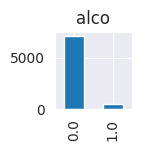

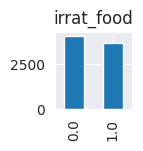

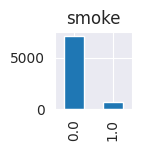

In [69]:
for column in restore_columns:
    df[column].value_counts().plot(kind='bar', title=column, figsize=(1, 1))
    plt.show()

Значения, свидетельствующие об употреблении алкоголя и табака практически отсутствуют, а значения иррациональности питания распределны практически равномерно. Заменять отсутствующие данные средними значениями в данном случае нецелесообразно. Попробуем Заполнить пропущенные значения с помощью метода N ближайших соседей, с учетом данных столбцов возраст, рост, вес, давление

In [70]:
imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)
columns = ['age', 'weight', 'height', 's_press', 'd_press', 'alco', 'irrat_food', 'smoke']
imputer.fit(df[columns])

KNNImputer()

In [71]:
df[columns] = imputer.transform(df[columns])

В результате работы алгоритма рассчитывается усредненное значение, округлим до целого, чтобы получить бинарные значения 0 или 1

In [72]:
for column in restore_columns:
    df[column] = np.round(df[column])

In [73]:
df.describe()

,age,weight,height,s_press,d_press,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
count,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000,9310.000000
mean,58.256498,75.294952,164.137809,127.077981,79.859936,0.055961,0.473255,0.077336,89.830505,3.974221,14.681847,0.581096
std,15.519359,15.534720,9.155431,12.634161,7.391681,0.229859,0.499311,0.267138,56.210986,7.220986,24.733695,0.493406
min,17.000000,32.000000,102.000000,72.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,65.000000,158.000000,120.000000,80.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000,0.000000
50%,60.000000,74.000000,164.000000,125.000000,80.000000,0.000000,0.000000,0.000000,78.000000,2.000000,5.000000,1.000000
75%,69.000000,84.000000,170.000000,130.000000,80.000000,0.000000,1.000000,0.000000,119.000000,5.000000,20.000000,1.000000
max,99.000000,176.000000,205.000000,200.000000,177.000000,1.000000,1.000000,1.000000,300.000000,100.000000,200.000000,1.000000


### Очистка данных от выбросов
Проверим данные в числовых столбцах на наличие выбросов

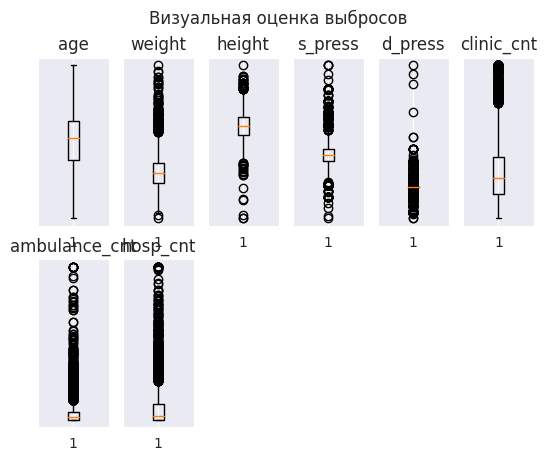

In [74]:
num_columns = ['age', 'weight', 'height', 's_press', 'd_press', 'clinic_cnt', 'ambulance_cnt', 'hosp_cnt']
for i, column in enumerate(num_columns):
    plt.subplot(2, 6, 1 + i)
    plt.title(column)
    plt.xticks([])
    plt.yticks([])
    plt.boxplot(df[column])
plt.suptitle("Визуальная оценка выбросов")
plt.show()

Оценим количество строк к удалению если оценивать выбросы с помощью интерквартильного размаха

In [75]:
outliers = set()
for column in num_columns:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    outliers = outliers.union(set(df[(df[column] < q1 - 1.5*iqr ) | (df[column] > q1 + 1.5*iqr)].index))
len(outliers)

6797

При удалении выбросов с использованием интерквартильного размаха удалению подлежит значительная часть данных. Построим гистограммы для указанных столбцов

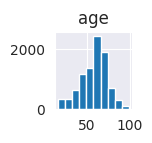

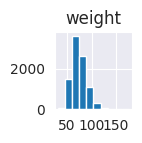

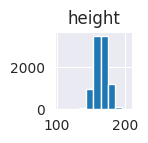

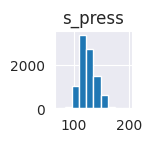

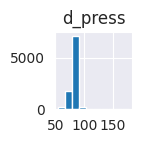

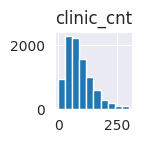

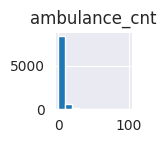

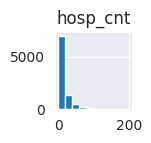

In [76]:
for column in num_columns:
    df.hist(column=column, figsize=(1, 1))
    plt.show()

Предположив, что данные в указанных столбцах распределены нормально, можно использовать критерий Шовене для выявления выбросов.
Согласно критерию Шовене, значение $p_i$ является выбросом при выполнении неравенства

$erfc(\frac{|p_i - \overline{p}|}{S_p}) < \frac{1}{2n}$

Создадим функцию для проверки значения на выброс с использованием функций math.erfc, при этом расчеты среднего по столбцу и стандартного отклонения вынесем из функции, чтобы вычислять их не для каждого значения, а один раз для всего столбца.

In [77]:
def chauvenet_filter(value, col_mean, col_stdev, to_cmp):
    return math.erfc(abs(value - col_mean) / col_stdev) < to_cmp

Оценим количество строк к удалению при использовании критерия Шовене

In [78]:
for column in num_columns:
    col_mean = df[column].mean()
    col_stdev = stdev(df[column])
    to_cmp = 1 / (2 * len(df[column].index))
    outliers = df[(df[column].apply(lambda value: chauvenet_filter(value, col_mean, col_stdev, to_cmp)))]
    print(f'{column} к удалению {len(outliers.index)} строк(и):')

age к удалению 0 строк(и):
weight к удалению 115 строк(и):
height к удалению 33 строк(и):
s_press к удалению 103 строк(и):
d_press к удалению 21 строк(и):
clinic_cnt к удалению 164 строк(и):
ambulance_cnt к удалению 177 строк(и):
hosp_cnt к удалению 203 строк(и):


Просмотрим визуально распределение данных, подлежащих удалению

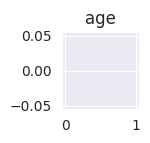

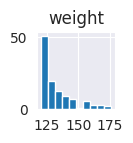

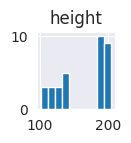

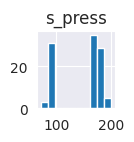

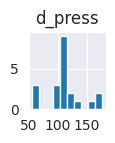

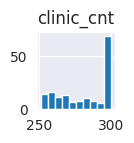

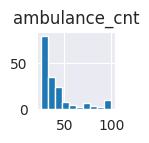

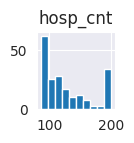

In [79]:
for column in num_columns:
    col_mean = df[column].mean()
    col_stdev = stdev(df[column])
    to_cmp = 1 / (2 * len(df[column].index))
    outliers = df[(df[column].apply(lambda value: chauvenet_filter(value, col_mean, col_stdev, to_cmp)))]
    outliers.hist(column=column, figsize=(1, 1))

Удалим выбросы с использованием критерия Шовене

In [80]:
for column in num_columns:
    col_mean = mean(df[column])
    col_stdev = stdev(df[column])
    to_cmp = 1 / (2 * len(df[column].index))
    outliers = df[(df[column].apply(lambda value: chauvenet_filter(value, col_mean, col_stdev, to_cmp)))]
    df.drop(labels=outliers.index, axis=0, inplace=True)
print(f'В датафрейме после удаления выбросов {len(df.index)} строк')

В датафрейме после удаления выбросов 8406 строк


### Нормализация числовых колонок и замена номинальных признаков
Выполним нормализацию значений числовых столбцов методом стандартизации (приведение к 𝑋̅ = 0, 𝑆 = 1). Перед нормализацией сохраним данные исходного датасета.

In [81]:
df_source = df.copy()

In [82]:
scaler = StandardScaler()
num_columns = ['age', 'weight', 'height', 's_press', 'd_press']
for column in num_columns:
    df[column] = scaler.fit_transform(df[[column]])

Заменим номинальные признаки sex и area на числовые

In [83]:
encoder = LabelEncoder()
encoder.fit(df['sex'])
df['sex'] = encoder.transform(df['sex'])
encoder.fit(df['area'])
df['area'] = encoder.transform(df['area'])

Приведем столбцы alco, irrat_food, smoke к целочисленному типу

In [84]:
for column in ['alco', 'irrat_food', 'smoke']:
    df = df.astype({column: np.int64})

## 1. Регрессия
В качестве целевого признака Y выберем clinic_cnt - количество услуг в поликлинике в течении года.
В качестве факторных признаков выберем:
- возраст,
- вес,
- рост,
- систолическое давление,
- диастолическое давление,
- пол,
- территория проживания,
- злоупотребление алкоголем (опрос),
- иррациональное питание (опрос),
- курение (опрос).

Проверим корреляцию между признаками

In [85]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,weight,height,s_press,d_press,sex,area,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk
age,1.000000,0.041814,-0.313588,0.421567,0.262416,-0.128440,-0.016995,-0.133295,0.009628,-0.136384,0.114745,0.171003,0.273306,0.516637
weight,0.041814,1.000000,0.358789,0.205664,0.179760,0.205389,0.007710,0.003798,0.084434,-0.003342,-0.000322,-0.008408,0.076905,0.147845
height,-0.313588,0.358789,1.000000,-0.114598,-0.043478,0.641668,-0.065687,0.075620,0.019734,0.174846,-0.173365,-0.030380,-0.037058,-0.178996
s_press,0.421567,0.205664,-0.114598,1.000000,0.594557,-0.004600,0.012628,-0.039464,0.083614,-0.055797,0.063198,0.108946,0.152848,0.413705
d_press,0.262416,0.179760,-0.043478,0.594557,1.000000,0.020266,0.015177,-0.011894,0.054635,-0.026253,0.032863,0.063546,0.094208,0.261291
sex,-0.128440,0.205389,0.641668,-0.004600,0.020266,1.000000,0.042513,0.059245,0.013227,0.244694,-0.220326,-0.023130,0.021357,-0.083266
area,-0.016995,0.007710,-0.065687,0.012628,0.015177,0.042513,1.000000,-0.008672,0.001845,0.092968,-0.007216,-0.139856,-0.023650,-0.015811
alco,-0.133295,0.003798,0.075620,-0.039464,-0.011894,0.059245,-0.008672,1.000000,0.058856,0.163227,-0.049011,-0.041825,-0.055626,-0.084504
irrat_food,0.009628,0.084434,0.019734,0.083614,0.054635,0.013227,0.001845,0.058856,1.000000,0.049747,0.000380,0.016176,0.013383,0.037074
smoke,-0.136384,-0.003342,0.174846,-0.055797,-0.026253,0.244694,0.092968,0.163227,0.049747,1.000000,-0.110821,-0.042530,-0.051614,-0.116074


Судя по данным матрицы имеется линейная зависимость меджу весом и ростом, а также показателями давления. Заменим указанные столбцы на отношение давлений press_ratio и индекс массы тела bmi.

In [86]:
df['press_ratio'] = df.s_press/df.d_press

In [87]:
df['bmi'] = df.weight / (df.height/100)**2

In [88]:
df = df[[column for column in df.columns if column not in(['s_press', 'd_press', 'weight', 'height'])]]

In [89]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,sex,area,alco,irrat_food,smoke,clinic_cnt,ambulance_cnt,hosp_cnt,has_bsk,press_ratio,bmi
age,1.000000,-0.128440,-0.016995,-0.133295,0.009628,-0.136384,0.114745,0.171003,0.273306,0.516637,0.262285,0.043639
sex,-0.128440,1.000000,0.042513,0.059245,0.013227,0.244694,-0.220326,-0.023130,0.021357,-0.083266,-0.036364,-0.010054
area,-0.016995,0.042513,1.000000,-0.008672,0.001845,0.092968,-0.007216,-0.139856,-0.023650,-0.015811,0.010851,0.020593
alco,-0.133295,0.059245,-0.008672,1.000000,0.058856,0.163227,-0.049011,-0.041825,-0.055626,-0.084504,-0.041604,0.010066
irrat_food,0.009628,0.013227,0.001845,0.058856,1.000000,0.049747,0.000380,0.016176,0.013383,0.037074,0.048113,0.018681
smoke,-0.136384,0.244694,0.092968,0.163227,0.049747,1.000000,-0.110821,-0.042530,-0.051614,-0.116074,-0.046541,-0.010762
clinic_cnt,0.114745,-0.220326,-0.007216,-0.049011,0.000380,-0.110821,1.000000,0.227609,0.344479,0.226824,0.071413,0.024918
ambulance_cnt,0.171003,-0.023130,-0.139856,-0.041825,0.016176,-0.042530,0.227609,1.000000,0.321173,0.217404,0.066689,0.008796
hosp_cnt,0.273306,0.021357,-0.023650,-0.055626,0.013383,-0.051614,0.344479,0.321173,1.000000,0.298509,0.102300,0.033277
has_bsk,0.516637,-0.083266,-0.015811,-0.084504,0.037074,-0.116074,0.226824,0.217404,0.298509,1.000000,0.285471,0.058594


Разобьем выборку на обучающую и тестовую в отношении 9 к 1

In [90]:
k = 10
x_columns = ['age', 'bmi', 'press_ratio', 'sex', 'has_bsk']
y_column = 'clinic_cnt'
x_train, x_test, y_train, y_test = train_test_split(df[x_columns], df[y_column], test_size=1/k)

Построим модель множественной линейной регрессии на обучающей выборке. выведем полученные коэффициенты и значение свободного члена.

In [91]:
model_regression = LinearRegression().fit(X=x_train, y=y_train)
print(f"Коэффициенты модели: {model_regression.coef_}, свободный член: {model_regression.intercept_}")

Коэффициенты модели: [-1.48975671e+00  4.98040927e-08  4.24932773e-02 -2.11429530e+01
  2.24972935e+01], свободный член: 79.38817024681228


Получим с помощью модели предсказанное целевое значение на тестовой выборке и оценим качество модели по метрикам MAE и MAPE.

Метрика MAE иллюстрирует среднюю абсолютную ошибку. Метрика MAPE иллюстрирует среднюю абсолютную ошибку в процентах.

In [92]:
y_pred = model_regression.predict(x_test)
print(f"MAPE = {metrics.mean_absolute_percentage_error(y_test, y_pred) * 100}%")

MAPE = 83.26952556932319%


In [93]:
print(f"MAE = {metrics.mean_absolute_error(y_test, y_pred)}")

MAE = 38.54985781177628


### Вывод:
Средняя ошибка предсказания модели составила 73% или 38 единиц в абсолютном выражении. Модель линейной регрессии не может предсказать количество услуг, оказанных пациенту в поликлинике за год, по выбранным показателям. Указанных данных явно недостаточно для предсказания количества оказанных услуг, т.к. услуги оказываются не только в связи с болезнями системы кровообращения.

## 2. Классификация
В качестве целевого признака Y выберем has_bsk - Наличие болезни системы кровообращения.
В качестве факторных признаков выберем:
- возраст,
- индекс массы тела,
- отношение давлений,
- пол,
- территория проживания,
- злоупотребление алкоголем (опрос),
- иррациональное питание (опрос),
- курение (опрос).

Разобьем выборку на обучающую и тестовую в отношении 2 к 1

In [94]:
x_columns = ['age', 'bmi', 'press_ratio', 'sex', 'area', 'alco', 'irrat_food', 'smoke']
y_column = 'has_bsk'
x_train, x_test, y_train, y_test = train_test_split(df[x_columns], df[y_column],
                                                    test_size=1/3, stratify=df[y_column])

Обучим на имеющихся данных маодель логистической регрессии

In [95]:
model = LogisticRegression().fit(X=x_train, y=y_train)

Получим с помощью модели предсказанное целевое значение на тестовой выборке и оценим качество модели по метрике F-measure.

Метрика F-measure представляет собой гармоническое среднее между точностью и полнотой. Она принимает значения от 0 до 1 и стремится к нулю, если точность или полнота стремится к нулю.

In [96]:
y_pred = model.predict(x_test)
print("F-measure:", metrics.f1_score(y_test, y_pred))

F-measure: 0.5707334028501911


Значение F-меры для обученной модели составило 0,57, что свидетельствует о низком качестве модели. Выведем метрики Precision и Recall, а также коэффициенты модели.

Precision (точность) - отношение TP к TP + FP. Это доля объектов, названными классификатором положительными и при этом действительно являющимися положительными

Recall (Полнота) - отношение TP к TP + FN. Это то, какую долю объектов положительного класса из всех объектов положительного класса нашёл алгоритм. 

In [ ]:
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

In [ ]:
print(f"Коэффициенты модели: {model.coef_}, свободный член: {model.intercept_}")

Для обучения модели использовались 8 признаков, попробем отобрать из них пять наиболее пригодных для построения моделей

In [ ]:
x_columns = ['age', 'bmi', 'press_ratio', 'sex', 'area', 'alco', 'irrat_food', 'smoke']
y_column = 'has_bsk'
feature_ratio = 5./len(x_columns)
selector = SequentialFeatureSelector(
    estimator=LinearRegression(),
    scoring=None,
    n_features_to_select=feature_ratio,
    direction="forward").fit(X=df[x_columns], y=df[y_column])
selected_features = selector.get_feature_names_out()
print(f"Выбранные признаки: {', '.join(selected_features)}")

Подготовим данные для модели с учетом выбранных признаков

In [ ]:
x_columns = selected_features
y_column = 'has_bsk'
x_train, x_test, y_train, y_test = train_test_split(df[x_columns], df[y_column], test_size=1/3, stratify=df[y_column])

Попробуем обучить модель Случайный лес 

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100).fit(X=x_train, y=y_train)

Выведем метрики для обученной модели

In [ ]:
y_pred = random_forest.predict(x_test)
print("F-measure:", metrics.f1_score(y_test, y_pred))

In [ ]:
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Качество обученной модели среднее, о чем свидетельствует значение F-меры 0,76. Значение точности 0,75 означает, что из 100 пациентов, для которых алгоритм предсказал наличие заболевания, только 75 имеют это заболевание в реальности. Значение полноты 0,77 означает, что из 100 реально больных пациентов алгоритм выявил только 77.

Выведем важность признаков, рассчитанную алгоритмом

In [ ]:
feature_imp = pd.Series(random_forest.feature_importances_,index=x_columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Важность признаков')
plt.title('Визуализация важных признаков')
plt.show()

График иллюсстирирует, что решения алгоритма основаны в большей части на трех признаках - возрасте, индексе массы тела и отношении давлений

## 3. Кластеризация

Попытаемся разделить пациентов на два кластера, предполагая, что в одном кластере будут пациенты с заболеванием системы кровообращения, а в другом без заболевания.

In [ ]:
x_columns = ['age', 'bmi', 'press_ratio', 'sex', 'area', 'alco', 'irrat_food', 'smoke']
y_column = 'has_bsk'
model_MST = MSTClustering(cutoff=2).fit(df[x_columns])

Получим предсказанные метки класса и оценим качество разбиения по метрикам ARI и Силуэт

In [ ]:
labels_pred = model_MST.fit_predict(df[x_columns])
print(f'ARI: {metrics.adjusted_rand_score(df[y_column], labels_pred)}')
print(f'силуэт: {metrics.silhouette_score(X=df[x_columns], labels=labels_pred)}')

Показатель ARI близок к нулю, что свидетельствует о том что разбиение практически не соотносится с истиными метками классов. Значение метрики Силуэт тоже близко к нулю, что показывает не существенное отличие расстояния между кластерами от расстояний внутри кластера.

Используя показатель Cилуэт можно попробовать построить модели с разным количеством кластеров и выбрать такое количество, при котором значение метрики Силуэт максимально.

In [ ]:
x_columns = ['age', 'bmi', 'press_ratio', 'sex', 'area', 'alco', 'irrat_food', 'smoke', 'has_bsk']

In [ ]:
max_val = [0,0]
for i in range(1,30):
    model_MST = MSTClustering(cutoff=i).fit(df[x_columns])
    value = metrics.silhouette_score(X=df[x_columns], labels=model_MST.fit_predict(df[x_columns]))
    if value > max_val[1]:
        max_val = [i, value]
print(f'максимальный показатель силуэт: {max_val[1]}, количество кластеров {max_val[0]}')

Попробуем провести кластеризацию с помощью алгоритма k-means

In [ ]:
max_val = [0,0]
for i in range(2,10):
    model_kmeans = KMeans(n_clusters=i, n_init='auto').fit(df[x_columns])
    pred_labels = model_kmeans.fit_predict(df[x_columns])
    value = metrics.silhouette_score(X=df[x_columns], labels=pred_labels)
    if value > max_val[1]:
        max_val = [i, value]
print(f'максимальный показатель силуэт: {max_val[1]}, количество кластеров {max_val[0]}')

Распределим пациентов по 3 кластерам

In [ ]:
model_kmeans = KMeans(n_clusters=3, n_init='auto').fit(df[x_columns])
pred_labels = model_kmeans.fit_predict(df[x_columns])

In [ ]:
df_source['clust'] = pred_labels

In [ ]:
df_source.clust.hist();

Два из трех клатеров получились очень малого размера, попробуем вернуть отдельные признаки рост/вес и давление

In [ ]:
back_columns = ['s_press', 'd_press', 'weight', 'height']
for column in back_columns:
    df[column] = df_source[column]

In [ ]:
scaler = StandardScaler()
for column in back_columns:
    df[column] = scaler.fit_transform(df[[column]])

Попытаемся построить разбиение по признакам возраст, давление, рост, вес, пол и наличие болезни системы кровообращения

In [ ]:
x_columns = ['age', 's_press', 'd_press', 'weight', 'height', 'sex', 'has_bsk']

In [ ]:
max_val = [0,0]
for i in range(2,10):
    model_kmeans = KMeans(n_clusters=i, n_init='auto').fit(df[x_columns])
    pred_labels = model_kmeans.fit_predict(df[x_columns])
    value = metrics.silhouette_score(X=df[x_columns], labels=pred_labels)
    if value > max_val[1]:
        max_val = [i, value]
print(f'максимальный показатель силуэт: {max_val[1]}, количество кластеров {max_val[0]}')

Разобьем пациентов на 2 кластера

In [ ]:
model_kmeans = KMeans(n_clusters=2, n_init='auto').fit(df[x_columns])
pred_labels = model_kmeans.fit_predict(df[x_columns])
df_source['clust'] = pred_labels
df_source.clust.hist();

В результате полученные кластеры сопоставимых размеров. Посмотрим разделение пациентов по кластеров в разрезе отдельных признаков

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

colors  = ['r', 'g', 'b']
classes = df_source['clust'].unique()
for i in range(len(classes)):
    cl = classes[i]
    ax1.scatter(
        df_source[df_source['clust'] == cl]['s_press'],
        df_source[df_source['clust'] == cl]['d_press'],
        c = colors[i], 
        s = 5,
        label = cl)
    ax1.set_title('Давление')
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Систолическое')
    ax1.set_ylabel('Диастолическое')

    ax2.scatter(
        df_source[df_source['clust'] == cl]['weight'],
        df_source[df_source['clust'] == cl]['height'],
        c = colors[i], 
        s = 5,
        label = cl)
    ax2.set_title('Вес/Рост')
    ax2.legend(loc='upper left')
    ax2.set_xlabel('Вес')
    ax2.set_ylabel('Рост')
plt.show()

Посмотрим разделение в трехмерном графике с осями возраст, рост, вес и текстовым признаком наличие заболевания 

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df_source, x='age', y='weight', z='height', color='clust',text='has_bsk')
fig.show()

### Вывод:
В результате получены два хорошо разделенных кластера, в первом соредоточены пациенты до 50 лет без избыточного веса и нормальным или пониженным давлением, а во втором пациенты старше 50 лет с избыточноым весом и повышенным давлением.

## Заключение
В результате проведенной работы по поставленным задачам получены следующие результаты:
1. Не удалось построить модель, предсказывающую количество оказанных пациенту поликлинических услуг.
2. Удалось построить модель среднего качества для определения у пациента наличия болезни системы кровообращения.
3. Удалось провести кластеризацию пациентов - разбиение на два хорошо различимых кластера.


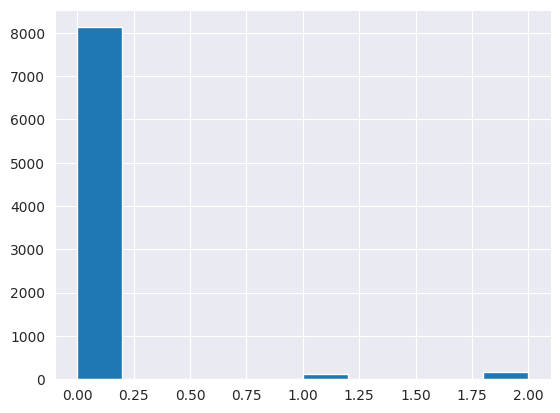

In [141]:
df_source.clust.hist();

Два из трех клатеров получились очень малого размера, попробуем вернуть отдельные признаки рост/вес и давление

In [134]:
back_columns = ['s_press', 'd_press', 'weight', 'height']
for column in back_columns:
    df[column] = df_source[column]

In [135]:
scaler = StandardScaler()
for column in back_columns:
    df[column] = scaler.fit_transform(df[[column]])

Попытаемся построить разбиение по признакам возраст, давление, рост, вес, пол и наличие болезни системы кровообращения

In [142]:
x_columns = ['age', 's_press', 'd_press', 'weight', 'height', 'sex', 'has_bsk']

In [143]:
max_val = [0,0]
for i in range(2,10):
    model_kmeans = KMeans(n_clusters=i, n_init='auto').fit(df[x_columns])
    pred_labels = model_kmeans.fit_predict(df[x_columns])
    value = metrics.silhouette_score(X=df[x_columns], labels=pred_labels)
    if value > max_val[1]:
        max_val = [i, value]
print(f'максимальный показатель силуэт: {max_val[1]}, количество кластеров {max_val[0]}')

максимальный показатель силуэт: 0.2151179609393467, количество кластеров 2


Разобьем пациентов на 2 кластера

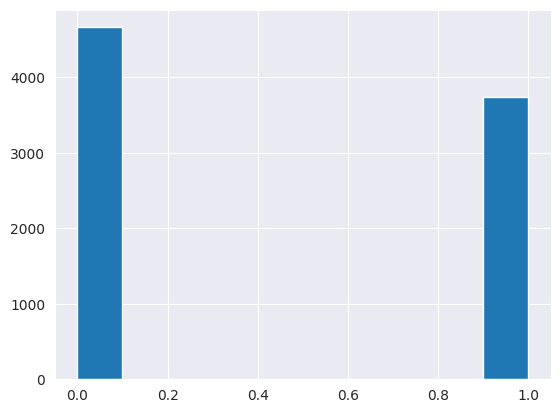

In [144]:
model_kmeans = KMeans(n_clusters=2, n_init='auto').fit(df[x_columns])
pred_labels = model_kmeans.fit_predict(df[x_columns])
df_source['clust'] = pred_labels
df_source.clust.hist();

В результате полученные кластеры сопоставимых размеров. Посмотрим разделение пациентов по кластеров в разрезе отдельных признаков

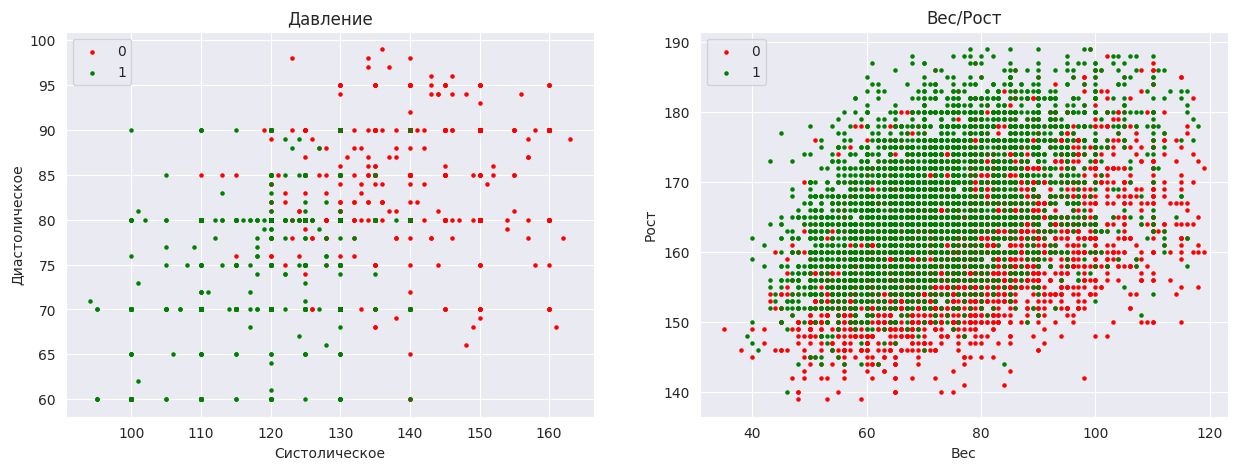

In [148]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

colors  = ['r', 'g', 'b']
classes = df_source['clust'].unique()
for i in range(len(classes)):
    cl = classes[i]
    ax1.scatter(
        df_source[df_source['clust'] == cl]['s_press'],
        df_source[df_source['clust'] == cl]['d_press'],
        c = colors[i], 
        s = 5,
        label = cl)
    ax1.set_title('Давление')
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Систолическое')
    ax1.set_ylabel('Диастолическое')

    ax2.scatter(
        df_source[df_source['clust'] == cl]['weight'],
        df_source[df_source['clust'] == cl]['height'],
        c = colors[i], 
        s = 5,
        label = cl)
    ax2.set_title('Вес/Рост')
    ax2.legend(loc='upper left')
    ax2.set_xlabel('Вес')
    ax2.set_ylabel('Рост')
plt.show()

Посмотрим разделение в трехмерном графике с осями возраст, рост, вес и текстовым признаком наличие заболевания 

In [153]:
import plotly.express as px
fig = px.scatter_3d(df_source, x='age', y='weight', z='height', color='clust',text='has_bsk')
fig.show()

### Вывод:
В результате получены два хорошо разделенных кластера, в первом соредоточены пациенты до 50 лет без избыточного веса и нормальным или пониженным давлением, а во втором пациенты старше 50 лет с избыточноым весом и повышенным давлением.

## Заключение
В результате проведенной работы по поставленным задачам получены следующие результаты:
1. Не удалось построить модель, предсказывающую количество оказанных пациенту поликлинических услуг.
2. Удалось построить модель среднего качества для определения у пациента наличия болезни системы кровообращения.
3. Удалось провести кластеризацию пациентов - разбиение на два хорошо различимых кластера.
